
I’ve been spending time exploring Ningchuan Xiao's excellent book, *GIS Algorithms*. This text offers a comprehensive dive into fundamental geospatial concepts including geometric algorithms, spatial indexing, and spatial analysis. The author thoroughly explains the theoretical foundations of each concept and provides practical Python implementations as examples.

In a series of upcoming posts, I’ll break down and share insights on these concepts one-by-one. In this post, we’ll focus on two straightforward geometric algorithms: calculating point-to-point and point-to-line distances. The accompanying code leverages the Shapely library to handle geometric primitives such as points and lines and to validate our custom implementations of each algorithm. 


## Point-to-Point Distance

We begin by computing the distance between two points in a rectilinear coordinate system. This can be accomplished using the Pythagorean theorem. For $p_{0} = (x_{0}, y_{0})$ and $p_{1} = (x_{1}, y_{1})$, the straight line distance $D$ between $p_{0}$ and $p_{2}$ is given by:

$$
D = \sqrt{(x_{1} - x_{0})^{2} + (y_{1} - y_{0})^{2}}. 
$$

In the next cell, `point2point` computes the distance between two points using the Pythagorean theorem:


In [ ]:

from math import sqrt
from shapely.geometry import Point


def point2point(p0, p1):
    """
    Return the distance between p1 and p2. 

    Parameters
    ----------
    p0: shapely.geometry.point.Point
        First point.

    p1: shapely.geometry.point.Point
        Second point.

    Returns
    -------
    float
        Straight-line distance between p0 and p1. 
    """
    x0: float = p0.x
    y0: float = p0.y
    x1: float = p1.x
    y1: float = p1.y
    return sqrt((x1 - x0)**2 + (y1 - y0)**2)


# Define two points.
p0 = Point(2., 3.)
p1 = Point(4., 7.)

# Compute distances using point2point and shapely. 
p2p = point2point(p0, p1)
shp = p0.distance(p1)

print(f"Distance using point2point: {p2p:.5f}")
print(f"Distance using shapely    : {shp:.5f}")


Distance using point2point: 4.47214
Distance using shapely    : 4.47214



<br>

If it is necessary to compute distance between two points on a sphere separated by a large extent, using `point2point` will not be accurate. We can instead opt for the haversine formula, which calculates the great-circle distance between two points on the Earth's surface. It is especially suited for applications where accuracy over large distances is critical. The `haversine` function in the next cell accepts two points, with `x` representing longitude and `y` latitude, and returns the great circle distance between them. To use the haversine formula, it is necessary to specify a value for the radius of the Earth. We use 6,371 km, a generally accepted value for the Earth's mean radius (see [here](https://www.movable-type.co.uk/scripts/latlong.html)):


In [2]:

from math import asin, cos, sin, radians


def get_haversine(p0, p1):
	"""
	Calculate the great circle distance between two points on the earth 
	(specified in decimal degrees).

	Parameters
	----------
		p0: shapely.geometry.point.Point
		First point with x = longitude and y = latitude.

	p1: shapely.geometry.point.Point
		Second point with x = longitude and y = latitude.

	Returns
	-------
	float
		Great circle distance between p0 and p1 in km.

	References
	----------
	http://www.movable-type.co.uk/scripts/latlong.html
	"""
	R: float = 6371.
	lon0: float = p0.x
	lat0: float = p0.y
	lon1: float = p1.x
	lat1: float = p1.y
	
	# Convert lat and lon degrees to radians.
	rlon0, rlat0, rlon1, rlat1 = map(radians, (lon0, lat0, lon1, lat1))
	dlon = rlon1 - rlon0
	dlat = rlat1 - rlat0
	a = sin(dlat / 2)**2 + cos(rlat0) * cos(rlat1) * sin(dlon / 2)**2
	c = 2 * asin(sqrt(a))
	return R * c


<br>

The pyproj library can be used to validate our haversine distance calculation. `p0` represents Chicago, Illinois and `p1` Burlington, Vermont. `pyproj.inv` returns the distance in meters, so we divide by 1000 to covert to km:

In [3]:

import pyproj

# p0 = Chicago, IL, p1 = Burlington, VT. 
p0 = Point(-87.6298, 41.8781)
p1 = Point(-73.2121, 44.4759) 

# Compute distances using get_haversine and geopy. 
get_haversine_dist = get_haversine(p0, p1)
geodesic = pyproj.Geod(ellps="WGS84")
_, _, pyproj_dist = geodesic.inv(*p0.coords[0], *p1.coords[0])

print(f"Distance (km) via get_haversine: {get_haversine_dist:,.0f}")
print(f"Distance (km) via pyproj       : {pyproj_dist / 1000:,.0f}")


Distance (km) via get_haversine: 1,203
Distance (km) via pyproj       : 1,205



The results are very close. We could get them to match exactly by tweaking the value used for the Earth's radius. 

<br>

## Point-to-Line Distance

In Chapter 2 of *GIS Algorithms*, a general expression for the distance from a point to a line in rectilinear coordinates is presented. The distance $D$ is defined as

$$ 
D = \frac{|ax_{0} + by_{0} + c|}{\sqrt{a^{2} + b^{2}}},
$$

where $ax_{0} + by_{0} + c$ is a line on the 2-D plane where $a, b$ and $c$ are constants. To obtain this expression, we calculate the distance from the point to the intersection point $(x_{1}, y_{1})$ between the line and a perpendicular line passing through $(x_{0}, y_{0})$.

Let $L = ax_{0} + by_{0} + c$. The slope of the line perpendicular to $L$ is $b / a$, therefore

$$
\frac{y_{1} - y_{0}}{x_{1} - x_{0}} = \frac{b}{a},
$$

resulting in

$$
a(y_{1} - y_{0}) - b(x_{1} - x_{0}) = 0.
$$

Squaring both sides and rearranging yields

$$
a^{2}(y_{1} - y_{0})^{2} + b^{2}(x_{1} - x_{0})^{2} = 2ab(x_{1} - x_{0})(y_{1} - y_{0}).
$$

After adding $a^{2}(x_{1} - x_{0})^{2} + b^{2}(y_{1} - y_{0})^{2}$ to both sides, the L.H.S. can be rewritten as

$$
(a^{2} + b^{2})\big((y_{1} - y_{0})^{2} + (x_{1} - x_{0})^{2}\big),
$$

and the R.H.S. as 

$$
(ax_{1} + by_{1} - ax_{0} - by_{0})^{2}.
$$

Since the intersection point $(x_{1}, y_{1})$ also falls on the original line $L$, $ax_{1} + by_{1} = -c$. Substituting this result within the R.H.S expression above gives us

$$
(a^{2} + b^{2})\big((y_{1} - y_{0})^{2} + (x_{1} - x_{0})^{2}\big) = (ax_{0} + by_{0} + c)^{2}.
$$
  

$(y_{1} - y_{0})^{2} + (x_{1} - x_{0})^{2}$ is the square of the distance between $(x_{0}, y_{0})$ and $L$. Rearranging, we obtain the original expression for $D$:

$$
D = \frac{|ax_{0} + by_{0} + c|}{\sqrt{a^{2} + b^{2}}}.
$$

<br>

In order to obtain the values for $a, b$ and $c$, we assume two endpoints that define a line segment $(x_{1}, y_{1})$ and $(x_{2}, y_{2})$. Let

$$
\begin{align*}
dx &= x_{1} - x_{2}\\
dy &= y_{1} - y_{2}\\
y &= \frac{dy}{dx}x + n,
\end{align*}
$$
 
where $n$ is a constant we need to compute. Plugging $(x_{1}, y_{1})$ into the last equation and solving for $n$ yields

$$
n = y_{1} - \frac{dy}{dx}x_{1}.
$$

Thus, a general form for the line can be expressed as

$$
y = \frac{dy}{dx}x + y_{1} - \frac{dy}{dx}x_{1}.
$$

Multiplying through by $dx$ and rearranging results in

$$
xdy - ydx + y_{1}dx -x_{1}dy = 0.
$$

Referring back to our original expression for $L$, it is easy to see that

$$
\begin{align*}
a &= dy\\
b &= -dx\\
c &= y_{1}dx - x_{1}dy.
\end{align*}
$$

<br>


Given a point $(x_{0}, y_{0})$ and a line segment $L$ defined by two endpoints $(x_{1}, y_{1})$ and $(x_{2}, y_{2})$, we can now determine the distance from $(x_{0}, y_{0})$ to the intersection point between $L$ and the perpendicular line passing through $(x_{0}, y_{0})$:

In [ ]:

from shapely.geometry import LineString


def point2line(p, l):
    """
    Compute distance between point p and line l.

    Parameters
    ----------
    p: shapely.geometry.point.Point
        Point of interest.
    l: shapely.geometry.linestring.LineString
        Line defined by two end points. 

    Returns
    -------
    float
        Distance from p to l. 
    """
    # Get endpoints from l. 
    p1, p2 = l.coords[:2]
    x0: float = p.x
    y0: float = p.y
    x1: float = p1[0]
    y1: float = p1[1]
    x2: float = p2[0]
    y2: float = p2[1]
    dx = x1 - x2
    dy = y1 - y2
    a = dy
    b = -dx
    c = y1 * dx - x1 * dy
    return abs(a * x0 + b * y0 + c) / sqrt(a**2 + b**2)



<br>

We create a line and point and use `point2line` to calculate the distance. The distance is also calculated using shapely to for verification:


In [28]:

p = Point(8., 3.)
l = LineString([[1., 1.], [5., 10.]])

point2line_dist = point2line(p, l)
shapely_dist = p.distance(l)

print(f"point2line distance: {point2line_dist:.5f}")
print(f"shapely distance   : {shapely_dist:.5f}")


point2line distance: 5.58440
shapely distance   : 5.58440



<br>

Let's visualize `p` and `l`, along with the line perpendicular to `l` passing through `p`:

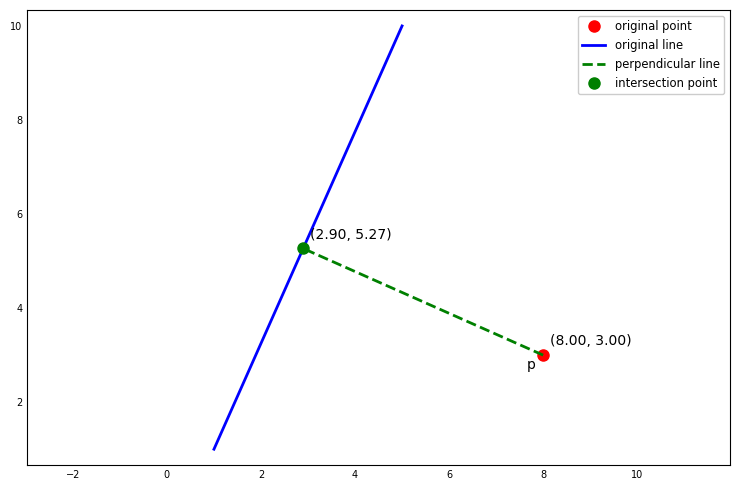

In [61]:

import matplotlib.pyplot as plt

# Determine slope and intercept of line perpendicular to l passing through p.
x0, y0 = p.coords[0]
(x1, y1), (x2, y2) = l.coords[:2]

# Get slope and intercept of l.
m = (y2 - y1) / (x2 - x1)
b = y1 - m * x1

# Get slope of line perpendicular to l.
mp = -1 / m

# Get intercept of line perpendicular to l that passes through (x0, y0).
bp = y0 - mp * x0

# Determine x and y where l and line perpendicular to l intersect. 
# The two points that define the line perpendicular to l are (x0, y0) 
# and (x_intersect, y_intersect).
x_intersect = (bp - b) / (m - mp)
y_intersect = m * x_intersect + b

# Group coordinates for plotting.
xx, yy = [x1, x2], [y1, y2]
xxp, yyp = [x0, x_intersect], [y0, y_intersect]


fig, ax = plt.subplots(1, 1, figsize=(7.5, 5.), tight_layout=True) 

# Plot point p.
ax.plot(x0, y0, "o", markersize=8, color="red", label="original point")

# Plot line segment l.
ax.plot(xx, yy, linewidth=2.0, color="blue", label="original line")

# Plot line segment perpendicular to l.
ax.plot(xxp, yyp, linewidth=2.0, color="green", linestyle="--", label="perpendicular line")

# Plot intersection point.
ax.plot(x_intersect, y_intersect, "o", markersize=8, color="green", label="intersection point")

ax.annotate(
    f"({x0:.2f}, {y0:.2f})", xy=(x0, y0), xycoords="data", ha="left", va="bottom", 
    textcoords="offset points", xytext=(5, 5), fontsize=10, rotation=0, weight="normal", 
    color="#000000"
) 

ax.annotate(
    "p", xy=(x0, y0), xycoords="data", ha="left", va="bottom", textcoords="offset points", 
    xytext=(-12, -12), fontsize=10, rotation=0, weight="normal", color="#000000"
) 

ax.annotate(
    f"({x_intersect:.2f}, {y_intersect:.2f})", xy=(x_intersect, y_intersect), 
    xycoords="data", ha="left", va="bottom", textcoords="offset points", 
    xytext=(5, 5), fontsize=10, rotation=0, weight="normal", color="#000000"
) 

ax.axis('equal')
ax.tick_params(axis="x", which="major", direction='in', labelsize=7)
ax.tick_params(axis="y", which="major", direction='in', labelsize=7)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.legend(loc="upper right", fancybox=True, framealpha=1, fontsize="small")
plt.show()



<br>

Since we have the endpoints of the line perpendicular to `l` passing through `p`, we can show that `point2point` returns the same distance as `point2line`:

In [ ]:

p1 = Point(x0, y0)
p2 = Point(x_intersect, y_intersect)

point2point(p1, p2)


5.584403908234904